# Evaluation of Surrogate Models

Currently we use `RandomForestRegressor(n_estimators=100)` to train a surrogate model mapping hyperparameters to performance.
Before training the performance is normalized s.t. the worst recorded performances on the task is 0, and the best recorded performance is 1.
For each task, we train a separate surrogate model.

A `Problem` object is created, which is a wrapper for a configuration that specifies which hyperparameters to model, and which experiment data or surrogate models to load.

In [21]:
import sys
sys.path.append("./src/")
from problem import Problem

problem = Problem("mlr_svm")

We can now expect the underlying experiment data for the "mlr svm" problem:

In [25]:
problem.data.sample(5)

,task_id,dataset,learner,target,perf.logloss,traintime,predicttime,kernel,cost,gamma,tolerance,shrinking,num.impute.selected.cpo,fitted,degree
355946,146800.0,MiceProtein,classif.svm,-0.450000,1.462339,18.657,0.917,radial,0.044552,0.000256,0.004221,TRUE,impute.hist,FALSE,NaN
443489,190412.0,arcene,classif.svm.radial,-0.310000,0.601490,201.231,55.572,radial,12.880400,0.000319,0.008296,TRUE,impute.hist,FALSE,NaN
116858,9956.0,one.hundred.plants.texture,classif.svm,-0.988117,4.566155,42.077,1.830,radial,0.248358,58.552500,0.000281,TRUE,impute.mean,FALSE,NaN
163447,9950.0,micro.mass,classif.svm.radial,-0.894918,2.914914,70.480,3.429,radial,164.407000,0.652217,0.003173,TRUE,impute.median,FALSE,NaN
319536,125921.0,LED.display.domain.7digit,classif.svm,-0.314000,1.165760,2.187,0.316,radial,28.437700,2602.260000,0.003942,FALSE,impute.mean,FALSE,NaN


We can also access the metadata for each task (though we don't need it here):

In [7]:
problem.metadata.sample(5)

,m,n,p,rc,mcp,mkd,xvar
task_id,,,,,,,
14,10,2000,76,0.000000,0.100000,0.006712,1.000000
3913,2,522,21,0.000000,0.795019,0.116184,1.000000
31,2,1000,61,0.885246,0.700000,0.008274,0.282451
9970,2,1212,100,0.000000,0.500000,0.651083,1.000000
3,2,3196,73,1.000000,0.522215,0.008077,0.249953


And access the surrogate model by task:

In [9]:
problem.surrogates[3893]

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

We will evaluate each surrogate model by its rmse, Spearman's $\rho$ and Kendall's $\tau$.
We use 10-fold cross-validation to obtain normalized score predictions for a surrogate model.

In [26]:
from scipy.stats import kendalltau, spearmanr, rankdata
from sklearn.metrics import mean_squared_error
import math

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

cache = {}

def performance_for_task(problem, task: int, on_training_data=False):
    """ returns surrogate model predicted normalized scores, and normalized observed scores. """
    if not on_training_data and (problem, task) in cache:
        return cache[(problem, task)]
    
    task_experiments = problem.data[problem.data.task_id == task]
    task_configurations = task_experiments[problem.hyperparameters]
    y = task_experiments.target
    normalized_scores = (y - min(y)) / (max(y) - min(y))
    
    if on_training_data:
        surrogate_scores = problem.surrogates[task].predict(task_configurations)
    else:
        surrogate = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        surrogate_scores = cross_val_predict(surrogate, task_configurations, normalized_scores, cv=10)
        cache[(problem, task)] = (surrogate_scores, normalized_scores)
    return surrogate_scores, normalized_scores

In [28]:
def calculate_rank_metrics(y_true, y_hat):
    """ Calculate Spearman's rho and Kendall's tau based on true and predicted model performance.
    
    Assumes that same index in y_true and y_hat represent the same sample.
    
    returns:
        - Spearman's rho
        - two-sided pvalue for rho
        - Kendall's tau
        - two-sided pvalue for tau
    """
    # Calculate orders
    true_order = rankdata(y_true, method='average')
    pred_order = rankdata(y_hat, method='average')
    
    rho, p_rho = spearmanr(true_order, pred_order)
    tau, p_tau = kendalltau(true_order, pred_order)
    return rho, p_rho, tau, p_tau  

In [29]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def distplot(surrogate, actual, ax, bin_zero=False):
    """ Plots the two distributions """
    _ = sns.distplot(surrogate, rug=True, kde=False, label='surrogate', ax=ax)
    _ = sns.distplot(actual, rug=True, kde=False, label='actual', ax=ax)
    _ = ax.set(xlabel='normalized score', ylabel='configurations', title=f'Distribution of Performance')
    # matplotlib inline will display the plot automagically
    
def scatter(df, x_col, y_col, c_col, title, ax, quantile=0.95):
    """ Scatterplot of (x_col, y_col) points, where the specified quantile is colored differently. """
    cut_off = df[c_col].quantile(quantile)
    df = df.assign(top_quantile=lambda r: r[c_col] > cut_off)
    ax = sns.scatterplot(x=x_col, y=y_col, hue="top_quantile", data=df, ax=ax)
    _ = ax.set(
        xscale="log", yscale="log", 
        xlim=(2**-32, 2**32), ylim=(2**-32, 2**32),
        title=title
    )

In [30]:
def score_surrogate(actual, predicted):
    """ Calculate some evaluation metrics for the surrogate model predictions. """
    rho, prho, tau, ptau = calculate_rank_metrics(actual, predicted)
    rmse = math.sqrt(mean_squared_error(actual, predicted))    
    return {
        "rho": rho,
        "prho": prho,
        "tau": tau,
        "ptau": ptau,
        "rmse": rmse,
        "quantile05": (actual - predicted).quantile(0.05),
        "quantile95": (actual - predicted).quantile(0.95)
    }

In [31]:
def incremental_rank_scores(actual, predicted, steps=20):
    rows = []
    for i in range(steps):
        ratio = i/steps
        cutoff = actual.quantile(ratio)
        
        actual_s = actual[actual > cutoff]
        predicted_s = predicted[actual > cutoff]
        rho, _, tau, _ = calculate_rank_metrics(actual_s, predicted_s)
        rows.append({'ratio': 1 - ratio, 'rho': rho, 'tau': tau})
    return rows

def rank_plot(actual, predicted, ax, steps=20):
    rows = incremental_rank_scores(actual, predicted, steps)
    df = pd.DataFrame(rows)
    sns.lineplot(x="ratio", y="rho", data=df, ax=ax, label="rho")
    sns.lineplot(x="ratio", y="tau", data=df, ax=ax, label="tau")
    ax.set(title='rho/tau on top x% of data')
    ax.set(xlabel="% of best configurations included", ylabel="correlation")
        

In [32]:
def plot_task_summary(problem, task):
    predicted, actual = performance_for_task(problem, task)
    
    unfiltered = score_surrogate(actual, predicted)
    scores = pd.DataFrame.from_dict(unfiltered, orient="index", columns=["unfiltered"])
    
    actual_filtered, predicted_filtered = actual[actual > 0], predicted[actual > 0]
    filtered = score_surrogate(actual_filtered, predicted_filtered)
    scores = scores.assign(filtered=filtered.values())
    
    top_10_percent = actual > actual.quantile(0.9)
    actual_10prct, predicted_10prct = actual[top_10_percent], predicted[top_10_percent]
    ten_percent = score_surrogate(actual_10prct, predicted_10prct)
    scores = scores.assign(ten_percent=ten_percent.values())
    
    print(f"Summary for Task {task}")
    print("The following dataframe shows rank metrics for the following subsets of configurations:")
    print(f" - unfiltered: calculated across all configurations ({len(actual)} points)")
    print(f" - filtered: calculated only on those configurations which scored higher than 0 normalized score ({sum(actual > 0)} points)")
    print(f" - filtered: calculated only on the top 10% of configurations ({sum(top_10_percent)} points)")
    with pd.option_context("display.float_format", "{:.4f}".format):
        display(scores.transpose())
        
    task_experiments = problem.data[problem.data.task_id == task]
    task_configurations = task_experiments[problem.hyperparameters]
    df = task_configurations.assign(actual=actual)
    df = df.assign(surrogate=predicted)
    df = df.assign(diff=abs(actual-surrogate))
        
    f, axes = plt.subplots(2, 2, figsize=(16, 7))
    # 4x4 plot. 
    # - score distributions
    # - score scatter: best 10% solutions, 10% greatest errors.
    # - same two plots with 0-score solutions left out.
    distplot(predicted, actual, axes[0, 0])
    df_filtered = df[df.actual > 0]
    # scatter(df_filtered, "gamma", "cost", "diff", "Biggest Mistakes Filtered (95%)", axes[1, 0])
    rank_plot(actual, predicted, axes[1, 0])
    scatter(df, "gamma", "cost", "actual", "Best Configurations (95%)", axes[0, 1])
    scatter(df, "gamma", "cost", "diff", "Biggest Mistakes (95%)", axes[1, 1])
    plt.tight_layout()

Summary for Task 3893
The following dataframe shows rank metrics for the following subsets of configurations:
 - unfiltered: calculated across all configurations (592 points)
 - filtered: calculated only on those configurations which scored higher than 0 normalized score (330 points)
 - filtered: calculated only on the top 10% of configurations (60 points)


,rho,prho,tau,ptau,rmse,quantile05,quantile95
unfiltered,0.9499,0.0000,0.8661,0.0000,0.0381,-0.0240,0.0260
filtered,0.9734,0.0000,0.8931,0.0000,0.0364,-0.0383,0.0379
ten_percent,0.6975,0.0000,0.5873,0.0000,0.0203,-0.0043,0.0630


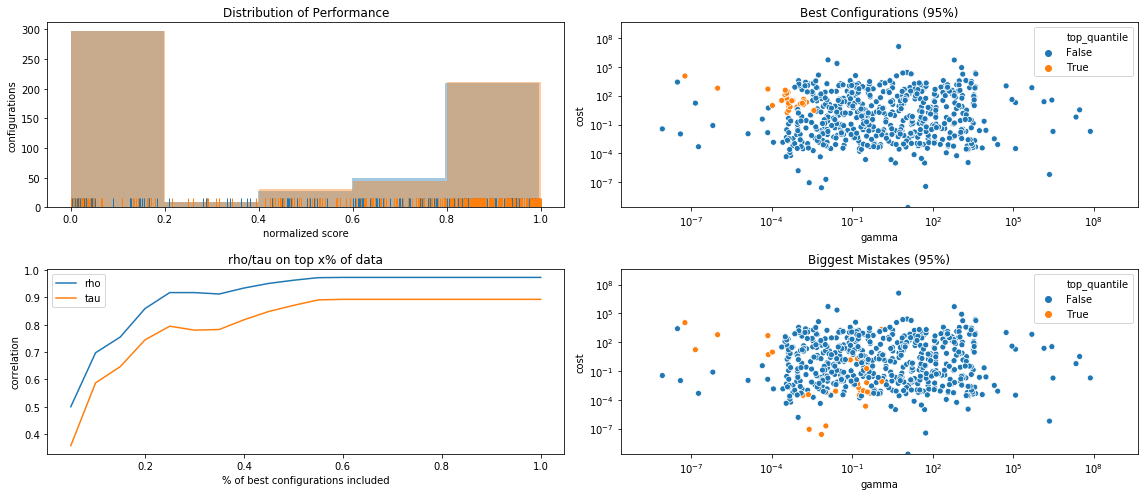

In [447]:
plot_task_summary(problem, task=3893)

In [33]:
data = df.pivot(index='gamma', columns='cost', values='d_score')
ax = sns.heatmap(data)
#ax.set(xlim=(9.29e-11, 3819), ylim=(8.28e-9, 54085))

NameError: name 'df' is not defined

-----

problem.data

In [390]:
rows = []
for i, task in enumerate(problem.data.task_id.unique()):
    print(f"{i:3d} / {len(problem.data.task_id.unique())}: {task}")
    predicted, actual = performance_for_task(problem, task)
    rows.append(score_surrogate(actual, predicted))

df = pd.DataFrame(rows)
df = df.assign(task=problem.data.task_id.unique())
df.head()

  0 / 106: 3893.0
  1 / 106: 3902.0
  2 / 106: 3903.0
  3 / 106: 3904.0
  4 / 106: 3907.0
  5 / 106: 3913.0
  6 / 106: 3917.0
  7 / 106: 3918.0
  8 / 106: 11.0
  9 / 106: 3945.0
 10 / 106: 12.0
 11 / 106: 14971.0
 12 / 106: 14.0
 13 / 106: 10090.0
 14 / 106: 14965.0
 15 / 106: 10093.0
 16 / 106: 10101.0
 17 / 106: 9981.0
 18 / 106: 9985.0
 19 / 106: 9986.0
 20 / 106: 14970.0
 21 / 106: 9970.0
 22 / 106: 9971.0
 23 / 106: 9976.0
 24 / 106: 9977.0
 25 / 106: 9978.0
 26 / 106: 9952.0
 27 / 106: 9956.0
 28 / 106: 9957.0
 29 / 106: 9960.0
 30 / 106: 15.0
 31 / 106: 9964.0
 32 / 106: 219.0
 33 / 106: 9946.0
 34 / 106: 9950.0
 35 / 106: 7592.0
 36 / 106: 16.0
 37 / 106: 18.0
 38 / 106: 2073.0
 39 / 106: 2074.0
 40 / 106: 2079.0
 41 / 106: 22.0
 42 / 106: 23.0
 43 / 106: 125920.0
 44 / 106: 24.0
 45 / 106: 28.0
 46 / 106: 29.0
 47 / 106: 3.0
 48 / 106: 3481.0
 49 / 106: 3022.0
 50 / 106: 31.0
 51 / 106: 3485.0
 52 / 106: 32.0
 53 / 106: 3493.0
 54 / 106: 37.0
 55 / 106: 3510.0
 56 / 106: 3512.

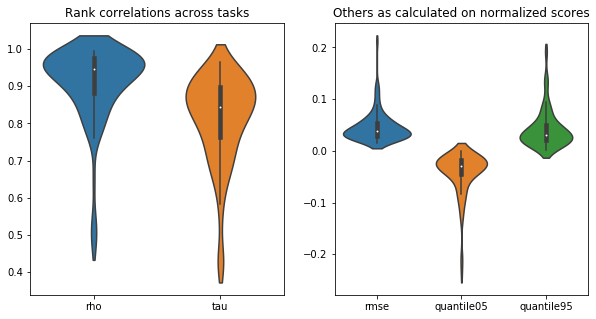

In [417]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
rank_metrics = df[['rho', 'tau']]
ax = sns.violinplot(data=rank_metrics, cut=1.0, ax=axes[0])
_ = ax.set(title='Rank correlations across tasks')

other_metrics = df[['rmse', 'quantile05', 'quantile95']]
ax = sns.violinplot(data=other_metrics, cut=1.0, ax=axes[1])
_ = ax.set(title='Others as calculated on normalized scores')

In [34]:
rows = []
for task in problem.data.task_id.unique():
    predicted, actual = performance_for_task(problem, task)
    inc_scores = incremental_rank_scores(actual, predicted)
    for score in inc_scores:
        score['task'] = task
    rows += inc_scores
    
df = pd.DataFrame(rows)

/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/flo/.local/lib/python3.6/site-packa

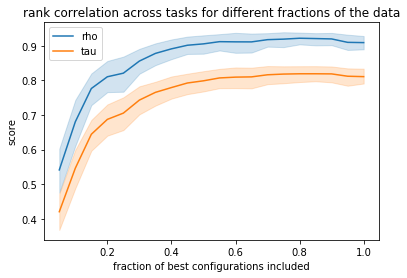

In [35]:
ax = sns.lineplot(x="ratio", y="rho", data=df, label="rho")
ax = sns.lineplot(x="ratio", y="tau", data=df, label="tau")
_ = ax.set(
    title="rank correlation across tasks for different fractions of the data",
    ylabel="score",
    xlabel="fraction of best configurations included"
)

----

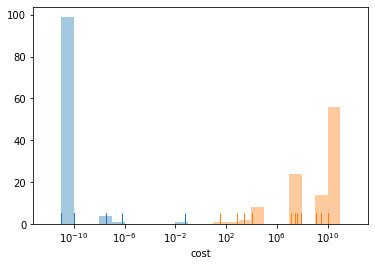

In [527]:
bins = list(np.logspace(-12, 12, 25))
ax = sns.distplot(problem.data.groupby(by='task_id').min().cost, kde=False, rug=True, bins=bins, label='min')
ax = sns.distplot(problem.data.groupby(by='task_id').max().cost, kde=False, rug=True, bins=bins, label='max')
ax.set_xscale("log")

In [37]:
problem.data.groupby(by='task_id').min().cost

task_id
3.0         1.008280e-11
6.0         9.296000e-11
11.0        1.008280e-11
12.0        1.008280e-11
14.0        1.008280e-11
15.0        1.008280e-11
16.0        1.008280e-11
18.0        1.008280e-11
22.0        1.008280e-11
23.0        1.008280e-11
24.0        9.296000e-11
28.0        9.296000e-11
29.0        1.008280e-11
31.0        1.008280e-11
32.0        9.296000e-11
37.0        1.008280e-11
41.0        1.008280e-11
43.0        9.296000e-11
45.0        9.296000e-11
49.0        1.008280e-11
53.0        1.008280e-11
58.0        9.296000e-11
219.0       3.546570e-08
2073.0      1.008280e-11
2074.0      9.296000e-11
2079.0      1.008280e-11
3021.0      1.008280e-11
3022.0      1.008280e-11
3481.0      9.296000e-11
3485.0      1.008280e-11
                ...     
145681.0    1.008280e-11
146195.0    3.546570e-08
146212.0    9.296000e-11
146607.0    9.296000e-11
146800.0    1.008280e-11
146817.0    1.008280e-11
146818.0    1.008280e-11
146819.0    1.008280e-11
146820.0    1.008

In [128]:
min(problem.data.groupby(by='task_id').max().cost)

31.8767

In [129]:
import itertools
import numpy as np

min_c = problem.data.groupby(by='task_id')

costs = np.geomspace(problem.data.cost.min(), problem.data.cost.max(), 200)
gammas = np.geomspace(problem.data.gamma.min(), problem.data.gamma.max(), 200)
configurations = list(itertools.product(costs, gammas))

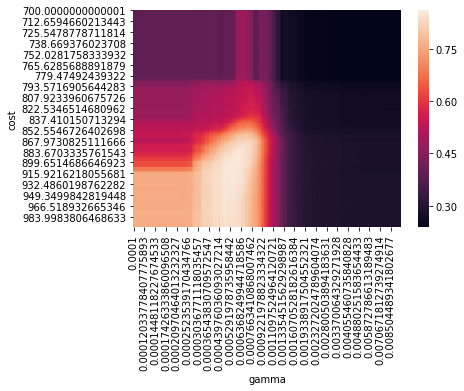

In [130]:
for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

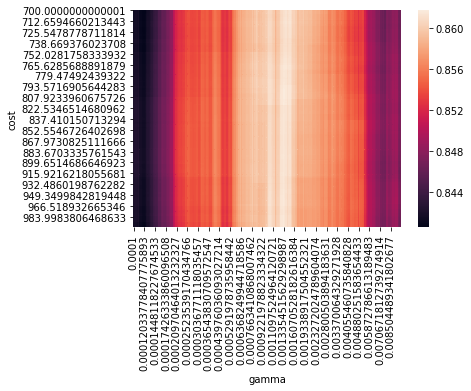

In [131]:
# Zoomed in:
costs = np.geomspace(7e2, 1e3, 200)
gammas = np.geomspace(1e-4, 1e-2, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

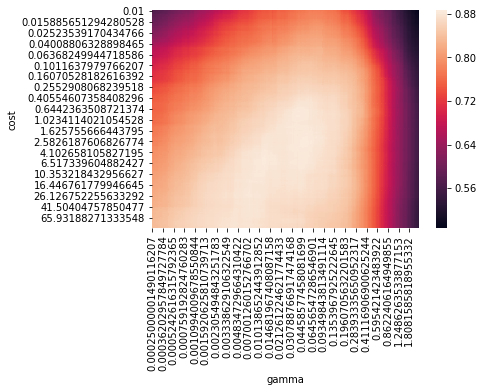

In [136]:
# Warp with metafeatures
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        costs =  np.geomspace(1e-2, 100, 200) * problem.metadata.loc[task, "m"]
        gammas = np.geomspace(1e-2, 100, 200) * problem.metadata.loc[task,"mkd"]
        configurations = list(itertools.product(costs, gammas))
        scores = surrogate.predict(configurations)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

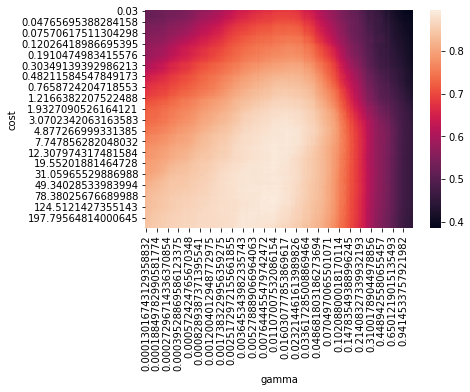

In [135]:
# Warp with metafeatures 1 / (p*xvar)
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        costs =  np.geomspace(1e-2, 100, 200)
        gammas = np.geomspace(1e-2, 100, 200) * (1 / problem.metadata.loc[task,"p"] / problem.metadata.loc[task,"xvar"]) 
        configurations = list(itertools.product(costs, gammas))
        scores = surrogate.predict(configurations)
        surrogate_scores[task] = scores
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

In [138]:
surrogate_scores.loc[surrogate_scores["mean"] > 0.8718,]

,cost,gamma,3902,3903,3904,3913,3917,3918,11,12,...,14969,3549,45,3560,3561,49,53,6,58,mean
15716,0.369691,0.053654,0.922060,0.957971,0.717831,0.767646,0.658558,0.234803,0.880613,0.994819,...,0.919321,0.994121,0.946655,0.483962,0.618491,0.612036,0.853442,0.996595,0.983291,0.872266
15717,0.369691,0.056195,0.918667,0.959010,0.713926,0.760174,0.652021,0.227698,0.879474,0.994857,...,0.919145,0.993538,0.947156,0.505561,0.616261,0.634113,0.851240,0.996595,0.983413,0.872729
15719,0.369691,0.061645,0.910899,0.958011,0.710674,0.718280,0.622798,0.243096,0.860322,0.994924,...,0.919066,0.993087,0.948038,0.515497,0.624072,0.691496,0.850596,0.996846,0.983446,0.872148
15910,0.387204,0.040644,0.943235,0.963685,0.714289,0.781456,0.767297,0.169602,0.886846,0.995832,...,0.919407,0.996266,0.947081,0.476645,0.627393,0.551357,0.861235,0.993788,0.985971,0.872753
15912,0.387204,0.044586,0.943102,0.962497,0.713399,0.770870,0.722434,0.185231,0.883297,0.995172,...,0.919407,0.996266,0.947785,0.472819,0.634000,0.570380,0.860680,0.994374,0.985257,0.872465
15913,0.387204,0.046698,0.936069,0.964702,0.709668,0.766338,0.713665,0.188072,0.880519,0.995001,...,0.919988,0.996266,0.948060,0.467660,0.634749,0.573969,0.860526,0.994411,0.985182,0.872188
15914,0.387204,0.048910,0.927141,0.964184,0.708601,0.767591,0.703460,0.173314,0.885804,0.994870,...,0.920876,0.996266,0.948116,0.466635,0.629997,0.578188,0.857467,0.995367,0.984980,0.872512
15915,0.387204,0.051227,0.921818,0.961796,0.708245,0.768594,0.693870,0.206191,0.882435,0.994770,...,0.921739,0.995064,0.949196,0.479168,0.623685,0.584540,0.855107,0.996354,0.983531,0.872817
15916,0.387204,0.053654,0.922954,0.957253,0.718186,0.768889,0.659782,0.235759,0.880421,0.994763,...,0.924667,0.994121,0.949196,0.484378,0.624430,0.627364,0.854430,0.996595,0.983247,0.873699
15917,0.387204,0.056195,0.919879,0.958349,0.714339,0.761417,0.652021,0.228178,0.879282,0.994800,...,0.924490,0.993538,0.950114,0.505696,0.622944,0.652332,0.851876,0.996595,0.983369,0.874221


In [139]:
surrogate_scores

,cost,gamma,3902,3903,3904,3913,3917,3918,11,12,...,14969,3549,45,3560,3561,49,53,6,58,mean
0,0.01,0.000250,0.787406,0.968270,0.523879,0.831446,0.587989,0.400736,0.760425,0.623235,...,0.573183,0.893278,0.739208,0.608715,0.361943,0.244210,0.230949,0.475740,0.598571,0.569510
1,0.01,0.000262,0.780767,0.968559,0.530741,0.855249,0.587985,0.399308,0.772268,0.623235,...,0.573183,0.893278,0.739208,0.656427,0.362189,0.247386,0.229793,0.475740,0.611599,0.572051
2,0.01,0.000274,0.823012,0.967901,0.535475,0.821763,0.547563,0.393596,0.758845,0.631063,...,0.574111,0.893278,0.739208,0.601289,0.362189,0.249321,0.230375,0.475740,0.613442,0.571129
3,0.01,0.000287,0.841071,0.964499,0.536480,0.814747,0.544288,0.394072,0.763624,0.631063,...,0.571537,0.893278,0.739208,0.616492,0.362807,0.249321,0.231382,0.478396,0.613442,0.571749
4,0.01,0.000301,0.820831,0.963441,0.532694,0.837209,0.549383,0.398356,0.765390,0.631063,...,0.577620,0.893278,0.739328,0.625264,0.356508,0.249682,0.231742,0.478396,0.616566,0.574312
5,0.01,0.000315,0.808394,0.965497,0.530030,0.875956,0.577533,0.405971,0.766143,0.631063,...,0.577616,0.893278,0.739328,0.612061,0.356508,0.249682,0.232532,0.546333,0.633619,0.577063
6,0.01,0.000330,0.826971,0.965152,0.528551,0.873168,0.582020,0.395500,0.766903,0.631817,...,0.581747,0.892596,0.742786,0.625661,0.354774,0.249713,0.231274,0.546440,0.634897,0.577513
7,0.01,0.000346,0.834651,0.966924,0.531155,0.862960,0.578552,0.407399,0.768611,0.631817,...,0.581767,0.892596,0.743259,0.667848,0.354774,0.250181,0.230117,0.569364,0.635273,0.579885
8,0.01,0.000362,0.841846,0.968010,0.530445,0.878845,0.570801,0.409303,0.770318,0.631817,...,0.581767,0.892596,0.743259,0.589336,0.354774,0.252592,0.227288,0.569364,0.660089,0.581219
9,0.01,0.000379,0.833697,0.968956,0.529144,0.882997,0.580800,0.409303,0.770530,0.631817,...,0.585840,0.892596,0.743259,0.581288,0.351577,0.256305,0.234872,0.569364,0.661905,0.583520


In [140]:
problem.surrogates

{3893: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False),
 3902: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False),
 3903: RandomForestRegressor(bootstrap=True, crite